# Sims

## Imports

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category="SymPyDeprecationWarning")
import kwant
import kwant.continuum
import numpy as np
import tinyarray as ta
import scipy
from tqdm.notebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16.0, 12.0]
import tinyarray as ta

## Definitions

In [3]:
s0 = np.identity(2)
sZ = np.array([[1.0, 0.0], [0.0, -1.0]])
sX = np.array([[0.0, 1.0], [1.0, 0.0]])
sY = np.array([[0.0, -1j], [1j, 0.0]])

sigma = {"0": s0, "X": sX, "Y": sY, "Z": sZ}

In [4]:
def hamiltonian(rashba=False, superconducting=False, micromagnets=False):
    hamiltonian_normal = (
        "A * (k_x**2 + k_y**2) * kron(sigma_z, sigma_0) +"
        "-mu_wire * kron(sigma_z, sigma_0) + "
        "0.5 * gfactor * bohr_magneton * B * kron(sigma_0, sigma_x)"
    )

    hamiltonian_rashba = "+ alpha_R * k_x * kron(sigma_z, sigma_y) + alpha_R * k_y * kron(sigma_z, sigma_x)"

    hamiltonian_superconducting = "+ delta * kron(sigma_x, sigma_0)"

    hamiltonian_micromagnets_x = "+ 0.5 * gfactor * bohr_magneton * M * sinM(x/period) * kron(sigma_0, sigma_x)"

    hamiltonian_micromagnets_y = "+ 0.5 * gfactor * bohr_magneton * M * cosM(y/period) * kron(sigma_0, sigma_y)"

    hamiltonian = (
        hamiltonian_normal
        + rashba * hamiltonian_rashba
        + superconducting * hamiltonian_superconducting
        + micromagnets * hamiltonian_micromagnets_x
        + micromagnets * hamiltonian_micromagnets_y
    )

    return hamiltonian

In [5]:
def norbitals(p):
    if p["delta"] == 0:
        return 2, False
    elif p["delta"] > 0:
        return 4, True
    else:
        raise ValueError

In [6]:
def magnetic_phase(position, p):
    counter = np.mod(position - (1 + p["barrier_length"]) * p["hopping_distance"], p["period"])
    theta = (counter / p["period"]) * 2 * np.pi
    return theta

In [7]:
def barrier_height_func(barrier_height, barrier_length, wire_length, wire_width, site):
    if barrier_region(site, wire_width, wire_length, barrier_length):
        i = site[1][1] // wire_width
        distance_from_centre = np.abs(((wire_length - 1) / 2) - i)
        dbarrier_height = barrier_height / barrier_length
        negative_distance_from_end = distance_from_centre - ((wire_length - 1) / 2)
        height = barrier_height + dbarrier_height * negative_distance_from_end
        return height
    else:
        raise IndexError("barrier_height called outside of barrier region")

In [8]:
def central_region(site, w, c_l, b_l, a):
    (x, y) = site.pos
    return b_l*a <= x < c_l*a + b_l*a and 0 <= y < w*a


def barrier_region(site, w, c_l, b_l, a):
    if type(site) == kwant.builder.Site:
        (x, y) = site.pos
    else:
        x = site // w
        y = site % w
    left_barrier = 0 <= x < b_l*a and 0 <= y < w*a
    right_barrier = c_l*a + b_l*a <= x < c_l*a + 2 * b_l*a and 0 <= y < w*a
    return left_barrier or right_barrier

In [9]:
def make_system(
#    p, onsite_wire=onsite_wire_sc, onsite_barrier=onsite_barrier, onsite_lead=onsite_lead, hopX=hopX, hopY=hopY, norbs=4
    w, c_l, b_l, central_ham, barrier_ham, a
):
    syst = kwant.Builder()

    wrapped_central_region = lambda site : central_region(site, w, c_l, b_l, a)
    wrapped_barrier_region = lambda site : barrier_region(site, w, c_l, b_l, a)

    syst.fill(barrier_ham, wrapped_barrier_region, (0, 0))
    syst.fill(central_ham, wrapped_central_region, (b_l*a, 0))
    syst.fill(barrier_ham, wrapped_barrier_region, (b_l*a + c_l*a, 0))

    def make_lead():#p=p, onsite_lead=onsite_lead, lead_hopX=lead_hopX, lead_hopY=lead_hopY, norbs=norbs):
        # Conservation law must separate the electron-hole degree of freedom -> tauZ
        # Particle-hole symmetry operator must be figured out for the Hamiltonian
        tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
        tau_y_sig_z = np.kron(np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]]))

        lead = kwant.Builder(
            kwant.TranslationalSymmetry((-a, 0)),
            conservation_law=-tau_z,
            particle_hole=tau_y_sig_z,
        )

        def lead_shape(site):
            (x, y) = site.pos
            return 0 <= x < 1 and 0 <= y < w*a

        lead.fill(barrier_ham, lead_shape, (0, 0))
        return lead

    # TODO Look into where the different chemical potentials are used for each lead
    l_lead = make_lead()#onsite_lead=onsite_l_lead)
    r_lead = make_lead()#onsite_lead=onsite_r_lead)
    syst.attach_lead(l_lead)
    syst.attach_lead(r_lead.reversed())

    return syst

In [10]:
def NIXIN(params):
    norbs, superconducting = norbitals(params)
    w = params['wire_width']
    c_l = params['wire_length'] - 2 * params['barrier_length']
    b_l = params['barrier_length']
    a = params['hopping_distance']
    central_ham = kwant.continuum.discretize(hamiltonian(True, superconducting, True), coords="xy", grid=a)
    barrier_ham = kwant.continuum.discretize(hamiltonian(True, False, True), coords="xy", grid=a)
    return make_system(w, c_l, b_l, central_ham, barrier_ham, a).finalized()

## Parameters

In [11]:
parameters = {
    "wire_width": 10, # [sites]
    "wire_length": 100, # [sites]
    "barrier_length": 10, # [sites]
    "stagger_ratio": 0.5, # []
    "period": 4800, # [Å]
    "M": 0, # [T]
    "m_max": 2.5, # [T]
    "hopping_distance": 100, # [Å]
    "added_sinusoid": True, # []
    "B": 0, # [T]
    "b_max": 2.5, # [T]
    "bohr_magneton": 58.0E-6, # [eV/T]
    "alpha_R": 0.32, # [eV Å]
    "delta": 180.0E-6, # [eV]
    "gfactor": 12.5, # []
    "effective_mass": 0.014, # [m_e]
    "mu_wire": 0.0E-3, # [eV]
    "mu_barrier": 18.0E-3, # [eV]
    "mu_lead": 0.0E-3, # [eV]
    "barrier_height": 0.02 # [eV]
}

parameters["A"] = 3.82 / parameters["effective_mass"]
parameters["sinM"] = np.sin
parameters["cosM"] = np.cos

## Simulation

In [12]:
tolerance=1e-5
syst = NIXIN(parameters)
energies = []
critB = 0

First I need to find the optimal chemical potential to caluclate this at. This is the chemical potential which offsets the particle in a box solution (remember they add, which is why the short axis is dominant).

In [13]:
temp_p = parameters.copy()
temp_p["B"]=0
temp_p["M"] = 0
temp_p["delta"]=0
temp_p["mu_wire"]=0
mu_syst=NIXIN(temp_p)
Ht = mu_syst.hamiltonian_submatrix(sparse=True, params=temp_p)
Ht = Ht.tocsc()
eigs = scipy.sparse.linalg.eigsh(Ht, k=2, sigma=0)
eigs = np.sort(eigs[0])
new_mu = (eigs[1]-eigs[0])/2

In [14]:
new_mu

0.0020579193574309976

In [15]:
newparams = parameters.copy()
newparams["mu_wire"] = new_mu + newparams["mu_wire"]

# B_values=np.linspace(0, 1, 51)
# for b in tqdm(B_values, desc="Spec",):
#     newparams["B"] = b
M_values=np.linspace(0, 1, 201)
newparams["B"] = 0
for m in tqdm(M_values, desc="Spec",):
    newparams["M"] = m
    H = syst.hamiltonian_submatrix(sparse=True, params=newparams)
    H = H.tocsc()
    # k is the number of eigenvalues, and find them near sigma.
    eigs = scipy.sparse.linalg.eigsh(H, k=20, sigma=0)
    eigs = np.sort(eigs[0])
    energies.append(eigs)

Spec:   0%|          | 0/201 [00:00<?, ?it/s]

[]

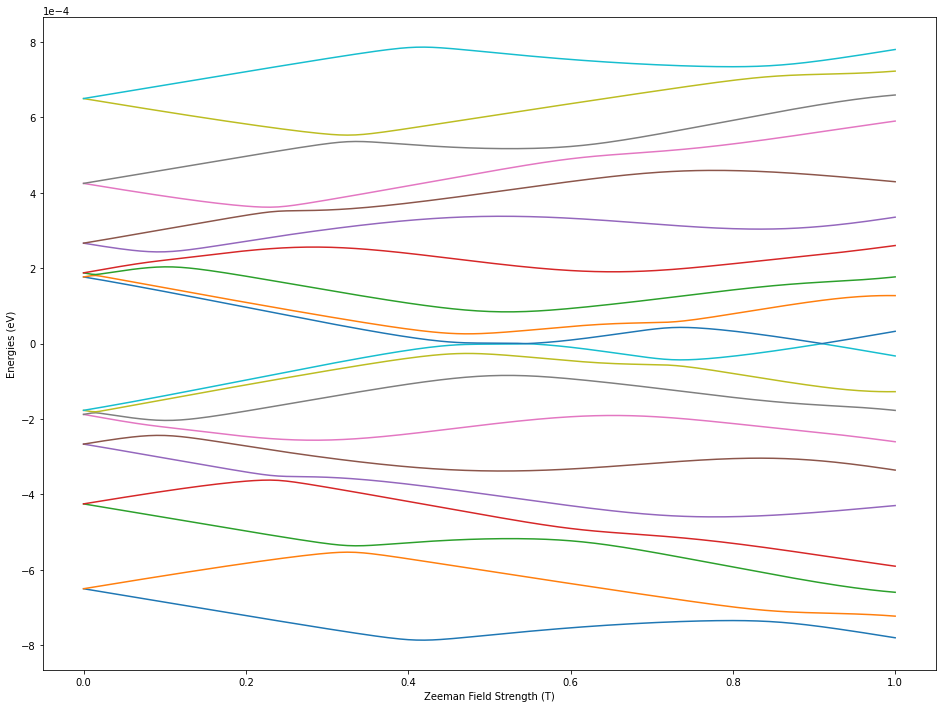

In [16]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (7, 5)
ax = fig.gca()
ax.plot(M_values, energies)
ax.set_xlabel("Zeeman Field Strength (T)")
ax.set_ylabel("Energies (eV)")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.plot()

## Model figure

In [22]:
w = parameters['wire_width']
c_l = parameters['wire_length'] - 2 * parameters['barrier_length']
b_l = parameters['barrier_length']
a = parameters['hopping_distance']

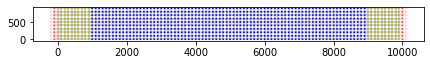

In [23]:
plot = kwant.plot(syst, show=True, site_color=lambda s: "y" if barrier_region(s, w, c_l, b_l, 1) else "b")

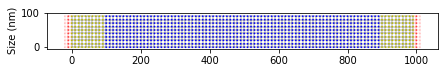

In [52]:
# fig = plt.figure()
# fig.suptitle("Model grid, and nanomagnet fields")
# ax_model = fig.add_axes()
# # ax_model.axis("equal")
# # nanowire.plot(ax_model, ax_x, ax_y)
plot = kwant.plot(syst, show=False, site_color=lambda s: "y" if barrier_region(s, w, c_l, b_l, 1) else "b")#,ax=ax_model)
ax = plot.gca()
ax.set_ylabel(r"Size (nm)")
ax.set_xticks([0,2000,4000,6000,8000,10000]) 
ax.set_xticklabels([0,200,400,600,800,1000])
ax.set_yticks([0,1000]) 
ax.set_yticklabels([0,100])
# ax_x.set_ylabel(r"$M_x$")
# ax_y.set_ylabel(r"$M_y$")
# ax_y.set_xlabel(r"Length ($\AA$)")
# xlim = fig.gca().figure.axes[0].dataLim.intervalx
# plt.xlim(xlim)
plot.savefig("C:\\Users\\mhynes\\Documents\\kwant-modelfig.eps", format="eps", dpi=1000,bbox_inches="tight")

## Band structure
Here I plot the band structure within a lead

In [93]:
newparams["alpha_R"]

0.32

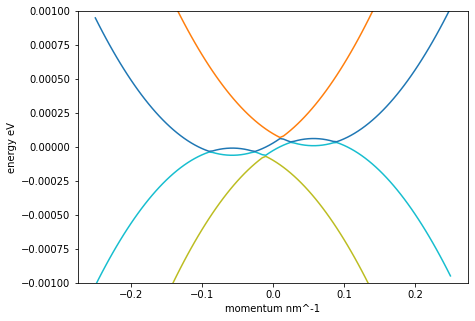

In [108]:
p = dict(newparams,M=0.1,B=0.0)
fig = kwant.plotter.bands(syst.leads[0], momenta=np.linspace(-0.25,0.25,101), show=False, params=p)
ax = fig.gca()
ax.set_ylim([-0.001,0.001])
plt.xlabel("momentum nm^-1")
plt.ylabel("energy eV")
plt.gca().get_lines()[0].set_color("black")
plt.show()

In [53]:
import matplotlib as mpl

# Bfields=np.linspace(0,2,200)
Vdata = []
energies = np.linspace(-0.0005,0.0005,201)
for e in tqdm(energies):
    E_data=[]
    for m in M_values:
#         plt.rcParams["figure.figsize"]= (8,5)  
        mode_info = syst.leads[0].modes(energy=e, params=dict(newparams, M=m))
        #smatrix = kwant.smatrix(syst,  params = dict(m_z = B))
        E_data.append((mode_info[0].block_nmodes[0]))  
            
    Vdata.append(E_data)

  0%|          | 0/201 [00:00<?, ?it/s]

In [62]:
syst.leads[0].modes(energy=0,params=dict(newparams,M=m))[0].block_nmodes

[1, 1]

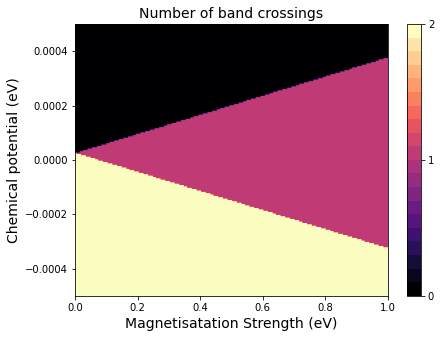

In [65]:
cbar = mpl.cm.get_cmap("magma", 20 )
            
plt.imshow(Vdata, aspect = 'auto',extent = [min(M_values), max(M_values), min(energies), max(energies)], cmap=cbar)
plt.xlabel("Magnetisatation Strength (eV)", fontsize=14)



#cbar.set_label("no of band crossings")
plt.ylabel("Chemical potential (eV)", fontsize=14)
plt.colorbar(ticks=np.linspace(0,4,5))
plt.title('Number of band crossings', fontsize=14 )
plt.show()

## Wavefunction

In [109]:
wf=kwant.wave_function(syst,energy=10.0E-3,params=dict(newparams,B=0.79))

C:\Users\mhynes\Miniconda3\envs\kwant\lib\site-packages\kwant\system.py:316: UserWarning: Hamiltonian breaks Particle-hole, ignoring the symmetry in the computation.
  warnings.warn('Hamiltonian breaks ' + name +


In [110]:
wf(0)

array([[-5.11298035e-01-2.04380046e-01j, -8.60887408e-02+3.77378390e-01j,
        -8.51355744e-06-8.32092607e-06j, ...,
         4.68305431e-01-2.89480222e-01j,  5.93566013e-06+5.15566907e-06j,
         6.94872856e-06-9.66477220e-06j],
       [-1.10548734e-01-1.76605146e-01j,  4.55124689e-01-4.94952305e-01j,
        -4.21867213e-07-9.70533371e-06j, ...,
        -1.19438567e-01-1.70646298e-01j, -9.09886414e-06+6.58224358e-06j,
        -8.77067710e-06-4.17740528e-06j],
       [-9.86406082e-01+1.01411655e+00j,  7.18575785e-01+3.97036926e-01j,
         4.05754224e-06+1.11265789e-06j, ...,
         4.28526608e-01+1.34812606e+00j,  3.51268068e-06-1.80221785e-06j,
        -4.12624251e-06-8.19865300e-07j],
       [-7.96726561e-01-1.66032627e-01j, -2.23990600e-01-1.44263404e+00j,
         2.69329798e-06+4.11067046e-06j, ...,
         8.13131152e-01+3.61045441e-02j,  9.12283014e-07+3.53232988e-06j,
        -3.62522921e-06+3.31764936e-06j]])

In [111]:
psi = wf(0)[1]

In [112]:
density = np.abs(psi)**2

In [113]:
s0 = np.identity(2)
sZ = np.array([[1.0, 0.0], [0.0, -1.0]])
sX = np.array([[0.0, 1.0], [1.0, 0.0]])
sY = np.array([[0.0, -1j], [1j, 0.0]])

pauli = {
    '0': s0,
    'X': sX,
    'Y': sY,
    'Z': sZ,
}

def t_s_(t,s):
    return ta.array(np.kron(pauli[t],pauli[t]))

In [160]:
rho = kwant.operator.Density(syst,t_s_('0','0'))

In [161]:
density = rho(psi)

In [162]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

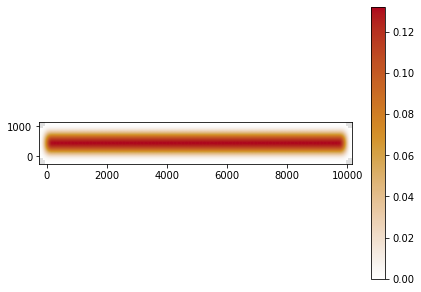

In [163]:
plot = kwant.plotter.density(syst,density)

### Declan's code

In [219]:
import scipy.sparse.linalg as sl
def calc_energies(fsyst, params, num_orbitals, num_states):
    ham = syst.hamiltonian_submatrix(params=params, sparse=True).tocsc()
    energies, states = sl.eigsh(ham, sigma=0, k=num_states)
    densities = (np.linalg.norm(states.reshape(-1, num_orbitals, num_states), axis=1) ** 2)
    return energies, states, densities

energies, states, densities = calc_energies(syst, dict(newparams,B=0.0,M=0.48), num_orbitals=4, num_states=2)

In [220]:
print(energies.shape)
print(states.shape)
print(densities.shape)

(2,)
(4000, 2)
(1000, 2)


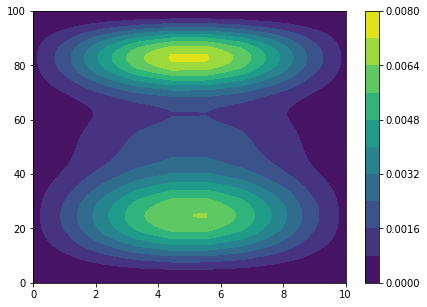

In [221]:
wfs1=[]
wfs2=[]
for x in range(1000):
    wfs1.append(densities[x][0])
    wfs2.append(densities[x][1])
   
WFS1=np.array(wfs1)
WFS2=np.array(wfs2)
WF=WFS1+WFS2
WFplot=WF.reshape(100,10)


xlist = np.linspace(0,10,10)
ylist = np.linspace(0,100,100)
X, Y = np.meshgrid(xlist, ylist)  
fig,ax=plt.subplots(1,1)

cp = ax.contourf(X, Y, WFplot,10)
fig.colorbar(cp) # Add a colorbar to a plot

# ax.set_title('Induced Gap in Spectrum (meV)')
# ax.set_xlabel('Magnetisation strength (meV)', fontsize=12)
# ax.set_ylabel('Chemical Potential (meV)', fontsize=12)
plt.show()

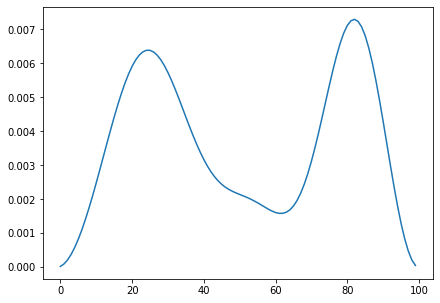

In [222]:
plt.plot(WFplot[:,4])